### Importing necessary packages

In [ ]:
# training and testing if made on google colaboratory
from google.colab import drive

drive.mount('/content/drive')

!pip3 install torch torchvision

In [ ]:
# uninstall the older version
!pip uninstall -y Pillow

# install the 5.3.0 version
!pip install Pillow==5.3.0

In [1]:
# necessary imports
import os
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import cv2

from collections import OrderedDict
from pydub import AudioSegment
from scipy import signal
from PIL import Image
from torchvision import transforms, models, datasets
from torch.utils.data import Dataset, DataLoader, TensorDataset

### Loading data

In [ ]:
# root path if remote
root_path = '/content/drive/My Drive/speech_recogniser/'

In [2]:
# root path if local
root_path = './'

In [3]:
data_dir = root_path + 'data'

train_dir = data_dir + '/train'
test_dir = data_dir + '/test'
valid_dir = data_dir + '/valid'

In [4]:
# helper function to resolve a file transcription
def resolve_transcription(files, transcription, relative_path = "./"):
    # our transcriptions
    transcriptions = []
    
    with open(relative_path + transcription, "r") as trans_file:
        # looping through each line from transcription
        for line in trans_file:
            # perform a single split, first match - audio source, second match - targets(text)
            match = line.split(" ", 1)
            
            # expecting two elements
            if(len(match) != 2):
                pass
                
            # our audio source with full name
            audio_source = match[0] + ".flac"

            # expecting the audio source to be present
            if(audio_source not in files):
                pass

            # append to our transcriptions
            transcriptions.append({
                "targets" : match[1][:-1],
                "audio" : relative_path + audio_source,
                "image" : relative_path + match[0] + ".png"
            })
                    
    return transcriptions    

# helper function to retrieve the paths
def resolve_data(dir_path):
    dirs = os.listdir(dir_path)

    transcriptions = []
    
    for directory in dirs:
        for sub_dir in os.listdir(dir_path + "/" + directory):
            # current directory
            curr_dir = dir_path + "/" + directory + "/" + sub_dir + "/"
            
            # files including images, audio files and text
            files = os.listdir(curr_dir)
            
            # filtering files by text
            files_text = [ file for file in files if file.endswith(".txt") ]
            
            # only one single transcription per directory source
            if(len(files_text) == 1):
                # our transcription to be resolved(link between the actual text and the audio source and image if exists)
                transcription = files_text[0]
                
                # resolved transcription with audio source and spectrogram(image path)
                resolved_transcription = resolve_transcription(files, transcription, relative_path = curr_dir)
                
                # concatenate with our raw list
                transcriptions += resolved_transcription

    return transcriptions

In [5]:
# data types
data_types = {"train" : train_dir, "valid" : valid_dir, "test" : test_dir}

# transcriptions holder
transcriptions = {data_type : resolve_data(data_dir) for data_type, data_dir in data_types.items()}

In [6]:
# default sampling rate
sampling_rate = 4096

# helper function to resolve an audio source file to spectrogram
def resolve_image_source(transcription, rewrite = False, interactive = False):
    # image source
    image_source = transcription["image"]
    
    # rewrite turned off and image source exists then show only
    image_save = not (not rewrite and os.path.isfile(image_source))
    
    # if not interactive and no rewriting is required then finish
    if(not (image_save or interactive)):
        return
    
    # audio source
    audio_source = transcription["audio"]
    
    if(audio_source.endswith((".flac", ".wav"))):
        raw = AudioSegment.from_file(audio_source)
    else: 
        raw = AudioSegment.from_mp3(audio_source)

    # single channel
    raw = raw.set_channels(1)
    
    # downsampling the audio source
    # raw = raw.set_frame_rate(sampling_rate)

    # retrieving data
    data = raw.get_array_of_samples()
    
    # data to numpy array
    data = np.array(data)
    
    # sample frequencies, segment times(0 <-> song's length), frequencies domain(last axis - segment times)
    f, t, Sxx = signal.spectrogram(data, raw.frame_rate, nfft = 320, nperseg = 320, noverlap = 0)
    
    # dimensions
    row, col = Sxx.shape[0], Sxx.shape[1]

    # normalizing dimensions
    row, col = 1.0, (col / row)
    
    fig = plt.figure(figsize = (col, row), dpi = 161)
    fig.subplots_adjust(0, 0, 1, 1)

    plt.set_cmap("gray")
    
    ax = fig.add_subplot(1, 1, 1, frameon = False)
    ax.pcolormesh(t, f, 10 * np.log10(Sxx))
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    if(image_save):
        plt.savefig(image_source)
    
    # don't show figure if not interactive
    if(not interactive):
        plt.close(fig)

# helper function to clean the generated spectrogram
def clean_image_source(transcription):
    # image source
    image_source = transcription["image"]
    
    # check if image source exists
    if(os.path.isfile(image_source) and not os.path.isdir(image_source)):
        os.remove(image_source)
        
# helper function to resolve all audio sources file to spectrograms
def resolve_transcription_images(transcriptions, rewrite = True, clean = False):
    
    # interactive mode turned off
    plt.ioff()
    
    for transcription in transcriptions:
        
        # clean all
        if(clean):
            clean_image_source(transcription)
            
        resolve_image_source(transcription, rewrite, interactive = False)
        
    # interactive mode turned on for default behaviour
    plt.ion()

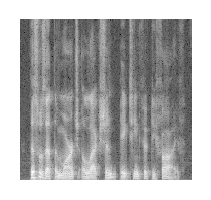

In [7]:
resolve_image_source(transcriptions["valid"][1], rewrite = False, interactive = True)

Generating for each audio source and image representing the spectrogram related to the audio source

In [8]:
for key, value in transcriptions.items():
    resolve_transcription_images(transcriptions[key], rewrite = False)

#### Finding the normalization parameters and adjusting the data accordingly

Padding uneven images with black color

In [9]:
# helper function to resolve the maximum dimensions in order to pad properly
def resolve_dimensions(transcriptions):
    # max width, height
    width, height = 0, 0
    
    for transcription in transcriptions:
        # open the image
        img = Image.open(transcription["image"])
        
        # current width and height of the image
        img_width, img_height = img.size
        
        # take the max
        width, height = max(width, img_width), max(height, img_height)
        
    return (width, height)

In [10]:
width_max, height_max = resolve_dimensions(transcriptions["test"])

print("Width: {}px, Height: {}px".format(width_max, height_max))

Width: 1747px, Height: 161px


In [11]:
# helper function to pad an image with black color the extended area
def resolve_images_pad(transcriptions, dimensions):
    
    for transcription in transcriptions:
        # open the image
        img = Image.open(transcription["image"])
        
        # retrieving the original size
        img_size = img.size
        
        # create a new image with size padded
        img_new = Image.new("RGB", dimensions)
        
        # past the image from top-left, given they have same height
        img_new.paste(img)

        # override the image from original source
        img_new.save(transcription["image"])

In [ ]:
for t in transcriptions.values():
    resolve_images_pad(t, dimensions = (width_max, height_max))

In [12]:
# helper function to generate image source, single channel image to be assumed
def generate_image_source(transcription):
    # get the image source
    img = Image.open(transcription["image"])

    # sample image
    return np.array(img, dtype = 'float32')[:, :, 0]

def per_sample(sample, mean):
    # flatten the array
    sample = sample.flatten()
        
    return ((sample - mean) ** 2).sum(), len(sample)

def generate_data_transforms(transcriptions):
    # mean and std
    mean, std = 0, 0
    
    # calculating mean of images
    for transcription in transcriptions:
        
        # acc the mean(_, _, 3)
        mean += generate_image_source(transcription).mean()
        
    # our mean
    mean = mean / len(transcriptions)
    
    # pixels count
    count = 0
    
    for transcription in transcriptions:
        sampl = per_sample(generate_image_source(transcription), mean)
        
        std += sampl[0]
        count += sampl[1]

    return mean, (std / count) ** (1 / 2)

In [13]:
# data transforms
trans_mean, trans_std = generate_data_transforms(transcriptions["train"])

In [14]:
print("Images: mean - {}, height - {}".format(trans_mean, trans_std))

Images: mean - 27.848273303682003, height - 57.71191479442374


In [15]:
def resolve_text_dict(ch, t, dic = None):    
    if(dic is not None and ch not in dic):
        dic.add(ch)
        
    t.append(ch)

# helper function to filter a text transcription
def resolve_transcription_filter(transcription, dic = None):
    # our new transcription
    t = []
    
    for ch in transcription:
        # ascii value
        a = ord(ch)
        
        if(a >= 65 and a <= 90):
            resolve_text_dict(a + 32, t, dic)
        elif((a >= 97 and a <= 122) or a == 32 or a == 39):
            resolve_text_dict(a, t, dic)
            
    return t

# helper function to resolve transcriptions text to filtered unique integer sequences
def resolve_transcriptions_text(transcriptions, character_max = None, character_to_int = None, int_to_character = None, character_set = None):
    
    seen_data = character_max is None and character_to_int is None
    
    if(seen_data):
        # our set with unique characters
        character_set = set()

        # max characters
        character_max = 0

    for transcription in transcriptions:

        # filtered transcription
        transcription["targets_f"] = resolve_transcription_filter(transcription["targets"], character_set)

        if(seen_data):
            # get max sequence length for padding
            character_max = max(character_max, len(transcription["targets"]))

    if(seen_data):
        # mapping dict from normalized ints to ascii(character); +1 as the 0 is label protected(CTCLoss)
        int_to_character = { index + 1 : ch for index, ch in enumerate(list(character_set)) }

        # mapping from ascii(character) to normalized ints
        character_to_int = { ch : index for index, ch in int_to_character.items() }
    
    for transcription in transcriptions:
        # original size before padding
        transcription["targets_size"] = len(transcription["targets"])
        
        # padding length to be appended
        padding_len = character_max - transcription["targets_size"]
        
        # ascii to normalized ints
        transcription["targets_f"] = [ character_to_int[ch] for ch in transcription["targets_f"] ] + [0] * padding_len
        
        
    return character_to_int, int_to_character, character_max

In [16]:
character_to_int, int_to_character, character_max = resolve_transcriptions_text(transcriptions["train"])

resolve_transcriptions_text(transcriptions["valid"], character_max, character_to_int)

({32: 1,
  39: 2,
  97: 3,
  98: 4,
  99: 5,
  100: 6,
  101: 7,
  102: 8,
  103: 9,
  104: 10,
  105: 11,
  106: 12,
  107: 13,
  108: 14,
  109: 15,
  110: 16,
  111: 17,
  112: 18,
  113: 19,
  114: 20,
  115: 21,
  116: 22,
  117: 23,
  118: 24,
  119: 25,
  120: 26,
  121: 27,
  122: 28},
 None,
 576)

Generating the data loaders for training and validating the model

In [18]:
# our batch size
batch_size = 32

def generate_dataloader(transcriptions):
    
    # our empty data
    features, targets, targets_size = [], [], []
    
    # dataset used as input to data loader
    for t in transcriptions:
        # normalizing features
        features.append((generate_image_source(t) - trans_mean) / trans_std)
        
        targets.append(t["targets_f"])
        
        targets_size.append(t["targets_size"])
        
    # to numpy
    features, targets, targets_size = np.array(features), np.array(targets), np.array(targets_size)
        
    # tensor dataset
    tensor_dataset = TensorDataset(torch.from_numpy(features),\
                                   torch.from_numpy(targets), torch.from_numpy(targets_size))
    
    return DataLoader(tensor_dataset, batch_size = batch_size, shuffle = True)

In [19]:
train_loader = generate_dataloader(transcriptions["train"])
valid_loader = generate_dataloader(transcriptions["valid"])

Device where the training process will be done, either on cpu or gpu if cuda is available.

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cpu


In [24]:
class Network(nn.Module):
    def __init__(self, output_size):
        super(Network, self).__init__()
        
        # conv1 => 1743 x 161
        self.conv1 = nn.Conv2d(1, 8, 7) 
        
        # pool1 => 872 x 81
        self.pool1 = nn.MaxPool2d(3, stride = 2, padding = 1)
        
        # conv2 => 870 x 80
        self.conv2 = nn.Conv2d(8, 16, 5)
        
        # pool2 => 435 x 40
        self.pool2 = nn.MaxPool2d(3, stride = 2, padding = 1)
        
        # conv3 => 435 x 40
        self.conv3 = nn.Conv2d(16, 32, 3, padding = 1)
        
        # pool3 => 218 x 20
        self.pool3 = nn.MaxPool2d(3, stride = 2, padding = 1)
        
        # conv4 => 218 x 20
        self.conv4 = nn.Conv2d(32, 32, 3, padding = 1)
        
        # pool4 => 108 x 10
        self.pool4 = nn.MaxPool2d(3, stride = 2, padding = 1)
        
        # conv5 => 108 x 10
        self.conv5 = nn.Conv2d(32, 32, 3, padding = 1)
        
        # pool5 => 54 x 5 => 32 x 54 x 5 => 160 x 54
        self.pool5 = nn.MaxPool2d(3, stride = 2, padding = 1)
        
        # gru layer
        self.gru = nn.GRU(input_size = 160, hidden_size = 512, num_layers = 2, batch_first = True)
        
        # dropout layer
        self.drp1 = nn.Dropout(0.25)
        
        # fully connected layer
        self.fc1 = nn.Linear(512, output_size)
        
    def forward(self, hidden):
        # 1st layer
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        
        # 2nd layer
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        
        # 3rd layer
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool3(x)
        
        # 4th layer
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool4(x)
        
        # 5th layer
        x = self.conv5(x)
        x = F.relu(x)
        x = self.pool5(x)
        
        # gru pass; first batch size 
        x, hidden = self.gru(x.view(batch_size, 54, -1), hidden)
        
        # stacking the gru layers 
        x = x.contiguous().view(-1, self.hidden_dim)
        
        x = nn.ReLU(self.fc1(self.drp1(x)))
        
        return nn.LogSoftmax(x.view(batch_size, 51, -1), dim = 2), hidden
    
    
model = Network(28)